In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_ta as ta
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
data = yf.download(tickers= 'BTC-USD', start = '2012-03-11', end='2023-07-10')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-07-05,30778.724609,30877.330078,30225.613281,30514.166016,30514.166016,12481622280
2023-07-06,30507.150391,31460.052734,29892.226562,29909.337891,29909.337891,21129219509
2023-07-07,29907.998047,30434.644531,29777.285156,30342.265625,30342.265625,13384770155


In [4]:
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=1000)
data['EMAS']=ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']=data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] =data['Adj Close'].shift(-1)


data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume','Close', 'Date'], axis=1, inplace=True)

In [5]:
data_set = data.iloc[:,0:11]
pd.set_option('display.max_columns', None)
data_set.head(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,2953.219971,2997.260010,2518.560059,2953.219971,59.850901,2537.318746,566.545597,1541.607258,2680.909912,1,2680.909912
1,2680.909912,2789.040039,2650.379883,2680.909912,61.461205,2554.433153,570.842250,1557.175639,2716.879883,1,2716.879883
2,2716.879883,2786.830078,2412.939941,2716.879883,53.087602,2549.855721,574.709438,1569.747751,2499.580078,1,2499.580078
3,2499.580078,2534.709961,2212.959961,2499.580078,51.593497,2541.734231,578.485403,1581.599835,2469.570068,1,2469.570068
4,2469.570068,2539.919922,2385.149902,2469.570068,53.408260,2539.527167,582.361677,1594.009904,2514.010010,1,2514.010010


In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.01555387 0.01406381 0.010467   ... 0.01140388 0.         0.01140388]
 [0.01140388 0.01094351 0.01250948 ... 0.01195206 0.         0.01195206]
 [0.01195206 0.0109104  0.00883047 ... 0.00864043 0.         0.00864043]
 ...
 [0.43547374 0.44059502 0.43460826 ... 0.42634271 0.         0.42634271]
 [0.42634271 0.4252287  0.4328273  ... 0.43303187 0.         0.43303187]
 [0.43303187 0.42432646 0.4375202  ... 0.43218894 0.         0.43218894]]


In [7]:
X=[]

backcandles=30
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi=np.array(X), np.array(data_set_scaled[backcandles:, -1])
y=np.reshape(yi,(len(yi),1))
print(X.shape)

print(y.shape)




2218
(2188, 30, 8)
(2188, 1)


In [8]:
splitlimit=int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1750
(1750, 30, 8)
(438, 30, 8)
(1750, 1)
(438, 1)
[[0.00716398]
 [0.00652223]
 [0.00453388]
 ...
 [0.57210662]
 [0.58697799]
 [0.5514976 ]]


In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np 

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs=LSTM(150, name='first_layer')(lstm_input)
inputs=Dense(1, name='dense_layer')(inputs)
output=Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

adam=optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
105/105 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 2/30
105/105 [==============================] - 1s 9ms/step - loss: 6.3007e-04 - val_loss: 0.0011
Epoch 3/30
105/105 [==============================] - 1s 9ms/step - loss: 6.4449e-04 - val_loss: 0.0021
Epoch 4/30
105/105 [==============================] - 1s 9ms/step - loss: 4.5934e-04 - val_loss: 0.0012
Epoch 5/30
105/105 [==============================] - 1s 9ms/step - loss: 5.3592e-04 - val_loss: 0.0011
Epoch 6/30
105/105 [==============================] - 1s 9ms/step - loss: 4.2751e-04 - val_loss: 0.0012
Epoch 7/30
105/105 [==============================] - 1s 9ms/step - loss: 3.9821e-04 - val_loss: 0.0012
Epoch 8/30
105/105 [==============================] - 1s 9ms/step - loss: 3.8523e-04 - val_loss: 0.0016
Epoch 9/30
105/105 [==============================] - 1s 9ms/step - loss: 4.1923e-04 - val_loss: 8.9728e-04
Epoch 10/30
105/105 [==============================] - 1s 9ms/s

In [10]:
y_pred=model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

14/14 [==============================] - 0s 4ms/step
[0.5603479] [0.56858352]
[0.567544] [0.57661782]
[0.57869107] [0.55889747]
[0.5639667] [0.54529441]
[0.5486474] [0.55686032]
[0.5557228] [0.55771257]
[0.5592962] [0.54582394]
[0.54864514] [0.57550727]
[0.57556623] [0.52791964]
[0.54333514] [0.51983212]


<function matplotlib.pyplot.show(close=None, block=None)>

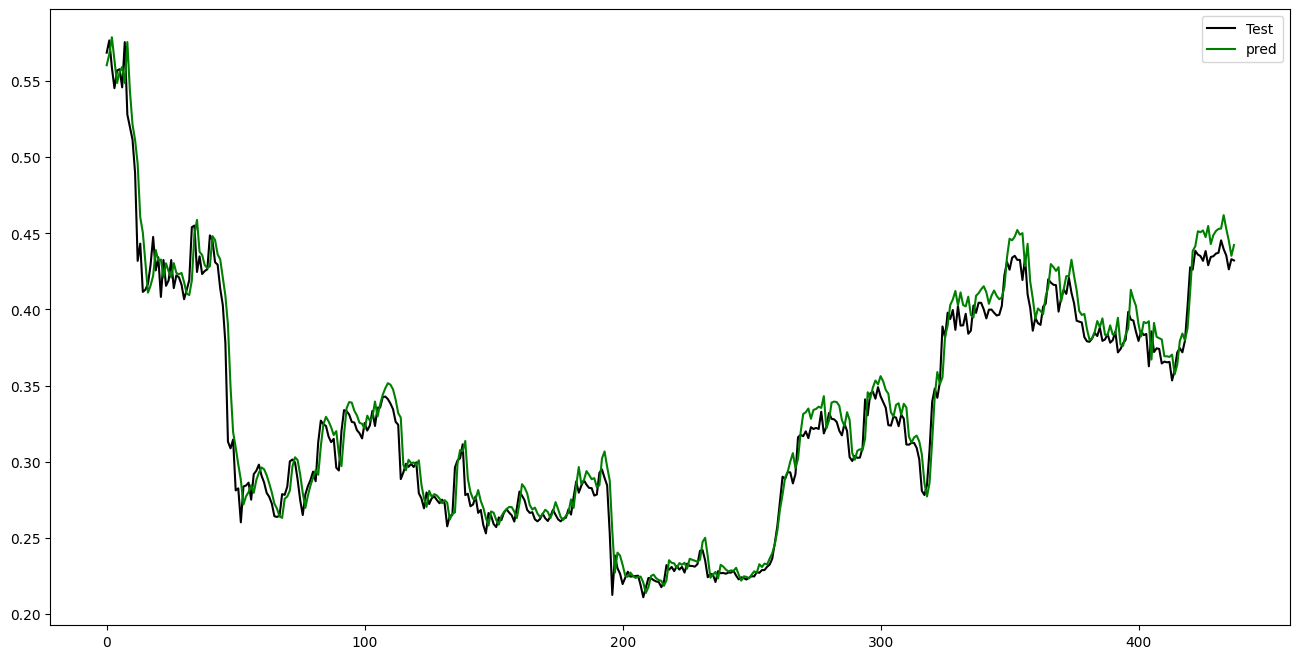

In [11]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color= 'black', label='Test')
plt.plot(y_pred, color = 'green', label= 'pred')

plt.legend()
plt.show